In [3]:
from osgeo import gdal
from datetime import date, datetime as dt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

## Read Planet Data

In [4]:
planet_fn = "/data/001_planet_sentinel_study/planet/utm11n_sur_ref/ndvi/planet_ndvi.vrt"
planet = gdal.Open(planet_fn)


planet_fns = planet.GetFileList()[1:]
planet_dates = [dt.strptime((f.split("/"))[-1][0:15], "%Y%m%d_%H%M%S") for f in planet_fns]

planet_ndvi = planet.ReadAsArray()
print planet_ndvi.shape

(182, 3424, 3421)


## Read Sentinel Data

In [6]:
sentinel_fn = "/data/001_planet_sentinel_study/sentinel/11SKA_NDVI/sen2_boa_ndvi.vrt"
sentinel = gdal.Open(sentinel_fn)

sentinel_fns = sentinel.GetFileList()[1:]
sentinel_dates = [dt.strptime((f.split("/"))[-1][5:20], "%Y%m%d_%H%M%S") for f in sentinel_fns]

sentinel_ndvi = sentinel.ReadAsArray()
print sentinel_ndvi.shape

# Get lat/lon information
transf = sentinel.GetGeoTransform()
reslon = transf[1]
reslat = transf[5]
cols = sentinel.RasterXSize
rows = sentinel.RasterYSize
LHS = transf[0]
THS = transf[3]
BHS = THS + (rows * reslat)
RHS = LHS + (cols * reslon)

latgrid = np.arange(THS, BHS, reslat)
longrid = np.arange(LHS, RHS, reslon)

(12, 3424, 3421)


## Extract Values from NDVI stack

In [24]:
# pixel_lat = 4061930
# pixel_lon = 235799

# Irrigation field
# pixel_lat = 4062600
# pixel_lon = 242386

# Bimodal field
pixel_lat = 4059460
pixel_lon = 235438

# 
# pixel_lat = 4056980
# pixel_lon = 240191

# pixel_lat = 4063520
# pixel_lon = 235633

win = 5

# ===== GET ROW/COLS FOR PIXEL LAT/LON ===== #

tpix_x = abs(longrid - pixel_lon).argmin()
tpix_y = abs(latgrid - pixel_lat).argmin()

print tpix_x, tpix_y

# ===== EXTRACT SENTINEL VALUES ===== #

sentinel_values = []
sentinel_std = []

for i in range(0, (sentinel_ndvi.shape)[0]):
        
    sentinel_values.append(np.nanmean(sentinel_ndvi[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    vals = sentinel_ndvi[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    sentinel_std.append(np.std(vals))
    
sentinel_df = pd.DataFrame(index = sentinel_dates)
sentinel_df['ndvi'] = sentinel_values
sentinel_df['std'] = sentinel_std

# ===== EXTRACT PLANET VALUES ===== #

planet_values = []
planet_std = []

for i in range(0, (planet_ndvi.shape)[0]):

    planet_values.append(np.mean(planet_ndvi[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1]))
    vals = planet_ndvi[i, tpix_y-win:tpix_y+win+1, tpix_x-win:tpix_x+win+1].flatten()
    planet_std.append(np.std(vals))
    

planet_df = pd.DataFrame(index = planet_dates)
planet_df['ndvi'] = planet_values
planet_df['std'] = planet_std

# Get rid of NaN values present in a row
#planet_df = planet_df[np.isfinite(planet_df['ndvi'])]

print "Done."

718 1571
Done.


## Extract Values from MODIS csv file

In [25]:
# ===== MCD43 OPENING... ===== #

mcd43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/bdrf-" + str(pixel_lon) + "-" + str(pixel_lat) + "/BDRF-" + str(pixel_lon) + "-" + str(pixel_lat) + "-MCD43A1-006-results.csv", index_col=2)

mcd43_df = pd.DataFrame(index = mcd43.index)
mcd43_df['nir_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
mcd43_df['nir_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_1']
mcd43_df['nir_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_2']

mcd43_df['red_iso'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
mcd43_df['red_vol'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_1']
mcd43_df['red_geo'] = mcd43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_2']

import xmltodict
import sys
import glob

sys.path.append('/home/tday/BEIS-LC/MODIS')

from Kernels import Kernels

def correction(fiso, fvol, fgeo, giso, gvol, ggeo):
    
    result = (fiso * giso) + (fvol * gvol) + (fgeo * ggeo)
    return result

# ===== Extract illumin conditions from planet xml ===== #

check_date = date(2017, 3, 1)

xmlfiles = sorted(glob.glob("/data/001_planet_sentinel_study/planet/utm11n_sur_ref/xml/*.xml"))

xdates = []
VAA = []
VZA = []
SZA = []
SAA = []
RO = []
LI = []

for xml in xmlfiles:
    
    xmldate = dt.strptime((xml.split("/"))[-1][0:8], "%Y%m%d").date()

    if xmldate == check_date:
        pass
        
    else:

        xdates.append(xmldate)
        
        with open(xml) as fd:
        
            doc = xmltodict.parse(fd.read())
            acq = doc['ps:EarthObservation']['gml:using']['eop:EarthObservationEquipment']['eop:acquisitionParameters']['ps:Acquisition']

            sazimuth = float(acq['opt:illuminationAzimuthAngle']['#text'])
            SAA.append(sazimuth)

            szenith = float(acq['opt:illuminationElevationAngle']['#text'])
            SZA.append(szenith)

            vazimuth = float(acq['ps:azimuthAngle']['#text'])
            VAA.append(vazimuth)

            vzenith = float(acq['ps:spaceCraftViewAngle']['#text'])
            VZA.append(vzenith)

            check_date = xmldate
            

            RAA = sazimuth - vazimuth

            kk = Kernels(vzenith, szenith, RAA, \
                 RossHS = False, RecipFlag = True, MODISSPARSE = True, \
                 normalise = 1, doIntegrals = False, LiType = 'Sparse', RossType = 'Thick' )

            RO.append(kk.Ross[0])
            LI.append(kk.Li[0])

bdrf_df = pd.DataFrame(index = xdates)  
bdrf_df['ROSS'] = RO
bdrf_df['LI'] = LI

CORR = pd.merge(bdrf_df, mcd43_df, left_index=True, right_index=True)

CORR['FINAL_nir'] = correction(CORR['nir_iso'], CORR['nir_vol'], CORR['nir_geo'], 1, CORR['ROSS'], CORR['LI'])
CORR['FINAL_red'] = correction(CORR['red_iso'], CORR['red_vol'], CORR['red_geo'], 1, CORR['ROSS'], CORR['LI'])
CORR['ndvi'] = ((CORR.FINAL_nir-CORR.FINAL_red)/(CORR.FINAL_nir+CORR.FINAL_red))

# Plot

<IPython.core.display.Javascript object>


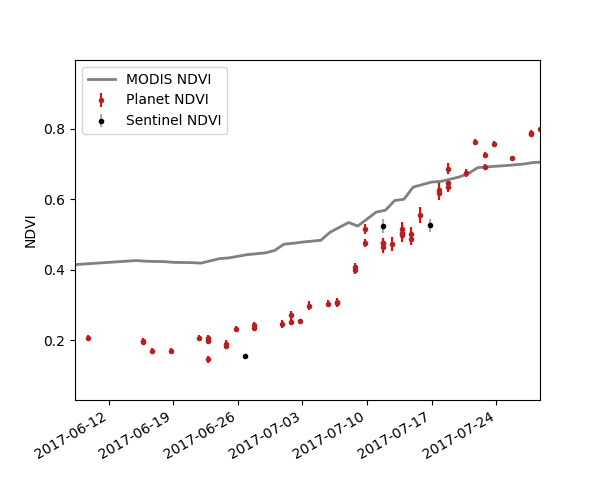

In [31]:
fig, ax = plt.subplots(figsize=(6,5))

# ax.plot_date(planet_df.index, planet_df['ndvi'], '-', color='Blue', linewidth=2)
# plt.scatter(planet_df.index, planet_df['ndvi'], color='Blue', label='PLANET', s=10)

# plt.scatter(CORR.index, CORR['ndvi'], color='Black', s=10)

ax.plot_date(CORR.index, CORR['ndvi'], '-', color='gray', linewidth=2, label='MODIS NDVI')



plt.errorbar(planet_df.index, planet_df['ndvi'], 
             yerr=planet_df['std'], fmt='o', ecolor='red', capthick=1, ms=3, color='firebrick',
             label='Planet NDVI')

plt.errorbar(sentinel_df.index, sentinel_df['ndvi'], 
             yerr=sentinel_df['std'], fmt='o', ecolor='darkgray', capthick=1, ms=3, 
             color='black', label='Sentinel NDVI')


# ax.plot_date(sentinel_df.index, sentinel_df['ndvi'], '-', color='red', linewidth=2)

fig.autofmt_xdate()
ax.set_xlim([date(2017, 3, 1), date(2017, 9, 30)])
ax.set_ylim([0, 1])
plt.legend(loc='top left')
plt.ylabel("NDVI")
plt.show()

<IPython.core.display.Javascript object>


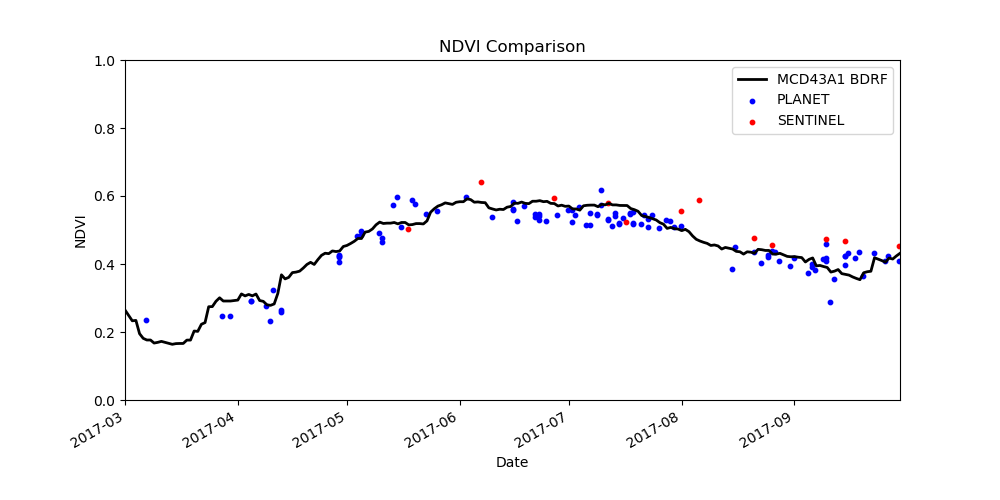

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

plt.scatter(planet_df.index, planet_df['ndvi'], color='Blue', label='PLANET', s=10)
# ax.plot_date(planet_df.index, planet_df['window'], '-', color='CornflowerBlue', linewidth=1)

# ax.plot_date(MOD09_df.index, MOD09_df['ndvi'], '-', color='darkgray', linewidth=2)
# ax.plot_date(MYD09_df.index, MYD09_df['ndvi'], '-', color='dimgrey', linewidth=2)
ax.plot_date(MCD43_df.index, MCD43_df['ndvi'], '-', color='Black', linewidth=2, label='MCD43A1 BDRF')

# ax.plot_date(sentinel_df.index, sentinel_df['ndvi'], '-', color='red', linewidth=2, label='SENTINEL 2')
plt.scatter(sentinel_df.index, sentinel_df['ndvi'], color='red', label='SENTINEL', s=10)
# ax.plot_date(sentinel_df.index, sentinel_df['window'], '-', color='lightcoral', linewidth=1)

fig.autofmt_xdate()
ax.set_xlim([date(2017, 3, 1), date(2017, 9, 30)])
ax.set_ylim([0, 1])


plt.title("NDVI Comparison")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


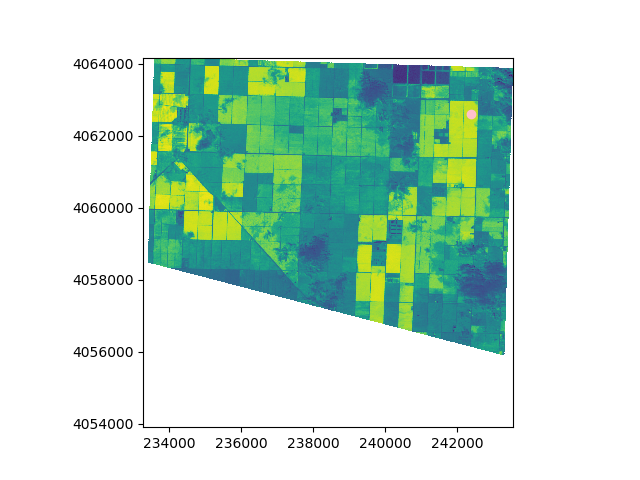

In [53]:
plt.imshow(planet_ndvi[11,:,:], extent=[LHS, RHS, BHS, THS])
plt.scatter(pixel_lon, pixel_lat, color='pink')
plt.show()

In [16]:
# # ===== MOD09 OPENING... ===== #

# MOD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MOD09/MOD09-MOD09GQ-006-results.csv", index_col=2)

# MOD09_df = pd.DataFrame(index = MOD09.index)
# MOD09_df['nir'] = MOD09['MOD09GQ_006_sur_refl_b02_1']
# MOD09_df['red'] = MOD09['MOD09GQ_006_sur_refl_b01_1']
# MOD09 = None

# MOD09_df = MOD09_df[MOD09_df.nir < 0.4]

# MOD09_df['ndvi'] = ((MOD09_df.nir-MOD09_df.red)/(MOD09_df.nir+MOD09_df.red))

# # ===== MYD09 OPENING... ===== #

# MYD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MYD09/MYD09-MYD09GQ-006-results.csv", index_col=2)

# MYD09_df = pd.DataFrame(index = MYD09.index)
# MYD09_df['nir'] = MYD09['MYD09GQ_006_sur_refl_b02_1']
# MYD09_df['red'] = MYD09['MYD09GQ_006_sur_refl_b01_1']
# MYD09 = None

# MYD09_df = MYD09_df[MYD09_df.nir < 0.4]

# MYD09_df['ndvi'] = ((MYD09_df.nir-MYD09_df.red)/(MYD09_df.nir+MYD09_df.red))
